# 02 - Modelo Siamese MFCC + deltas + más ejemplos negativos.
*Monserrat Montero T.*

### ¿Qué cambios se aplicaron respecto a Modelo 02?
+ Cambio de un Modelo clasificador a uno Siamese para incluir el audio de estudio y poder abordar canciones nuevas en tests.
+ Aumento de datos obtenidos de cada clip de solo MFCC a MFCC + deltas + más ejemplos negativos par mejorar la robustez
+ Aumento de ventanas por clip. (Primero en testing pero finalmente en entrenamiento.)
+ Cambio a Triplet Loss/ Contrastive Loss para que el modelo aprenda relaciones relativas, no absolutas. Así tolerará variaciones.


##### Dataset

In [ ]:
from pathlib import Path
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

# --- Configuración general ---
sr_target = 48000
n_mfcc = 20
hop_length = 512
ventana = 93
salto = 46  # 50% superposición

# Dataset de etiquetas
ruta_excel = Path("etiquetado.xlsx")
df = pd.read_excel(ruta_excel)

def convertir_a_segundos(valor):
    if isinstance(valor, str) and ":" in valor:
        minutos, segundos = map(int, valor.split(":"))
        return minutos * 60 + segundos
    if isinstance(valor, (int, float)) and valor >= 0:
        return int(valor)
    return -1

df["segundo_label"] = df["segundo_inicio"].apply(convertir_a_segundos)

# Eliminar columnas específicas que no usaremos para entrenamiento
df = df.drop(columns=["Unnamed: 7", "Unnamed: 8", "Unnamed: 5", "Unnamed: 6"], errors="ignore")

df_validos = df[df["segundo_label"] >= 0].reset_index(drop=True)
df_validos


,audio_base,carpeta,archivo_clip,segundo_inicio,duracion_clip,segundo_label
0,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip01.mp4,00:00,15,0
1,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip02.mp4,00:15,15,15
2,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip03.mp4,00:30,15,30
3,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip04.mp4,00:45,15,45
4,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip05.mp4,01:00,15,60
...,...,...,...,...,...,...
191,tu_me_dejaste_de_querer_c_tangana.mp3,clips_youtube,clip07.mp4,01:47,15,107
192,tu_me_dejaste_de_querer_c_tangana.mp3,clips_youtube,clip08.mp4,02:03,15,123
193,tu_me_dejaste_de_querer_c_tangana.mp3,clips_youtube,clip09.mp4,02:18,15,138
194,tu_me_dejaste_de_querer_c_tangana.mp3,clips_youtube,clip10.mp4,02:33,15,153


In [61]:
# --- Función para obtener MFCC stacked ---
def mfcc_stacked(audio):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr_target, n_mfcc=n_mfcc, hop_length=hop_length)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    return librosa.util.normalize(np.vstack([mfcc, delta, delta2]))

# --- Función para obtener ventanas ---
def extraer_ventanas(matriz, salto_frames=salto):
    ventanas = []
    for i in range(0, matriz.shape[1] - ventana + 1, salto_frames):
        submat = matriz[:, i:i + ventana]
        if submat.shape[1] == ventana:
            ventanas.append(submat.mean(axis=1))
    return ventanas

# --- Tripletas finales ---
anchors = []
positives = []
negatives = []

for _, fila in tqdm(df_validos.iterrows(), total=len(df_validos)):
    base_audio = Path(fila["audio_base"]).stem
    carpeta = fila["carpeta"].strip().strip("/").strip("\\")
    clip_nombre = fila["archivo_clip"].replace(".mp4", ".wav")
    segundo_real = fila["segundo_label"]

    # Rutas
    ruta_clip = Path("clips_syntrack") / base_audio / carpeta / "wavs" / clip_nombre
    ruta_estudio = Path("clips_syntrack") / base_audio / "cancion_estudio" / f"{base_audio}.wav"

    if not ruta_clip.exists() or not ruta_estudio.exists():
        print(f"⚠️  Faltan archivos para: {ruta_clip} o {ruta_estudio}")
        continue

    # Cargar y procesar clip
    try:
        clip_audio, _ = librosa.load(ruta_clip, sr=sr_target)
        stacked_clip = mfcc_stacked(clip_audio)
        ventanas_clip = extraer_ventanas(stacked_clip)
        if len(ventanas_clip) == 0:
            continue
    except:
        continue

    # Cargar y procesar canción de estudio
    try:
        estudio_audio, _ = librosa.load(ruta_estudio, sr=sr_target)
        stacked_estudio = mfcc_stacked(estudio_audio)
    except:
        continue

    # --- Ventana positiva ---
    frame_pos = int((segundo_real * sr_target) / hop_length)
    if frame_pos + ventana > stacked_estudio.shape[1]:
        continue
    vec_pos = stacked_estudio[:, frame_pos:frame_pos + ventana].mean(axis=1)

    # --- Ventanas negativas ---
    segundos_totales = stacked_estudio.shape[1] * hop_length // sr_target
    segundos_negativos = [s for s in range(5, segundos_totales - 5) if abs(s - segundo_real) > 3]

    if len(segundos_negativos) < 2:
        continue
    segundos_negativos = np.random.choice(segundos_negativos, 2, replace=False)

    vec_negs = []
    for s_neg in segundos_negativos:
        f_neg = int((s_neg * sr_target) / hop_length)
        if f_neg + ventana <= stacked_estudio.shape[1]:
            vec_neg = stacked_estudio[:, f_neg:f_neg + ventana].mean(axis=1)
            vec_negs.append(vec_neg)

    if len(vec_negs) < 2:
        continue

    # --- Generar tripletas ---
    for v_anchor in ventanas_clip:
        anchors.append(v_anchor)
        positives.append(vec_pos)
        negatives.append(vec_negs[0])  # puedes alternar o generar 2 tripletas

        anchors.append(v_anchor)
        positives.append(vec_pos)
        negatives.append(vec_negs[1])

anchors = np.array(anchors)
positives = np.array(positives)
negatives = np.array(negatives)

print(f"✅ Dataset de tripletas generado: {anchors.shape}, {positives.shape}, {negatives.shape}")

100%|██████████| 196/196 [01:53<00:00,  1.73it/s]

✅ Dataset de tripletas generado: (12012, 60), (12012, 60), (12012, 60)


In [62]:
from sklearn.model_selection import train_test_split

# --- División entrenamiento / validación
A_train, A_val, P_train, P_val, N_train, N_val = train_test_split(
    anchors, positives, negatives, test_size=0.2, random_state=42
)

# --- Dataset de entrenamiento
train_ds = tf.data.Dataset.from_tensor_slices(((A_train, P_train, N_train), tf.zeros(len(A_train))))
train_ds = train_ds.shuffle(buffer_size=1024).batch(64).prefetch(tf.data.AUTOTUNE)

# --- Dataset de validación
val_ds = tf.data.Dataset.from_tensor_slices(((A_val, P_val, N_val), tf.zeros(len(A_val))))
val_ds = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)

##### Modelo

In [64]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# Dimensión de entrada (MFCC + delta + delta2)
input_dim = anchors.shape[1]

# --- Encoder compartido ---
def build_encoder():
    inp = Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inp)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32)(x)  # No activación final
    return Model(inp, x, name="Encoder")

encoder = build_encoder()

# --- Inputs tripleta ---
anchor_input = Input(shape=(input_dim,))
positive_input = Input(shape=(input_dim,))
negative_input = Input(shape=(input_dim,))

# --- Pasar por encoder ---
encoded_anchor = encoder(anchor_input)
encoded_positive = encoder(positive_input)
encoded_negative = encoder(negative_input)

# --- Modelo final ---
triplet_model = Model(
    inputs=[anchor_input, positive_input, negative_input],
    outputs=[encoded_anchor, encoded_positive, encoded_negative]
)
triplet_model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_24      │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_25      │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder             │ (None, 32)        │     18,144 │ input_layer_23[0… │
│ (Functional)        │                   │            │ input_layer_24[0… │
│                     │                   │            │ input_layer_25[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,144 (70.88 KB)

 Trainable params: 18,144 (70.88 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# --- Función de pérdida personalizada ---
def triplet_loss_fn(margin=0.5):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        return tf.reduce_mean(tf.maximum(pos_dist - neg_dist + margin, 0.0))
    return loss


In [70]:
# Modificar la clase TripletModel
class TripletModel(tf.keras.Model):
    def __init__(self, encoder, margin=0.5):
        super().__init__()
        self.encoder = encoder
        self.margin = margin
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.val_loss_tracker = tf.keras.metrics.Mean(name="val_loss")

    def compile(self, optimizer, **kwargs):
        super().compile(optimizer=optimizer, **kwargs)

    def train_step(self, data):
        (anchor, positive, negative), _ = data

        with tf.GradientTape() as tape:
            emb_anchor = self.encoder(anchor, training=True)
            emb_positive = self.encoder(positive, training=True)
            emb_negative = self.encoder(negative, training=True)

            # Calcular triplet loss
            pos_dist = tf.reduce_sum(tf.square(emb_anchor - emb_positive), axis=1)
            neg_dist = tf.reduce_sum(tf.square(emb_anchor - emb_negative), axis=1)
            loss = tf.reduce_mean(tf.maximum(pos_dist - neg_dist + self.margin, 0.0))

        grads = tape.gradient(loss, self.encoder.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        (anchor, positive, negative), _ = data
        
        emb_anchor = self.encoder(anchor, training=False)
        emb_positive = self.encoder(positive, training=False)
        emb_negative = self.encoder(negative, training=False)

        # Calcular triplet loss para validación
        pos_dist = tf.reduce_sum(tf.square(emb_anchor - emb_positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(emb_anchor - emb_negative), axis=1)
        loss = tf.reduce_mean(tf.maximum(pos_dist - neg_dist + self.margin, 0.0))
        
        self.val_loss_tracker.update_state(loss)
        return {"loss": self.val_loss_tracker.result()}

    def call(self, inputs):
        anchor, positive, negative = inputs
        emb_a = self.encoder(anchor)
        emb_p = self.encoder(positive)
        emb_n = self.encoder(negative)
        return emb_a, emb_p, emb_n

    @property
    def metrics(self):
        return [self.loss_tracker, self.val_loss_tracker]


##### Entrenamiento

In [71]:

# Compilar y entrenar
final_model = TripletModel(encoder)
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

history = final_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2339 - val_loss: 0.1988
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1788 - val_loss: 0.1564
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1357 - val_loss: 0.1328
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1050 - val_loss: 0.0986
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0777 - val_loss: 0.0766
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0637 - val_loss: 0.0633
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0506 - val_loss: 0.0555
Epoch 8/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0441 - val_loss: 0.0480
Epoch 9/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0363 - val_loss: 0.0469
Epoch 10/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0322 - val_loss: 0.0353
Epoch 11/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0267 - val_loss: 0.0431
Epoch 12/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

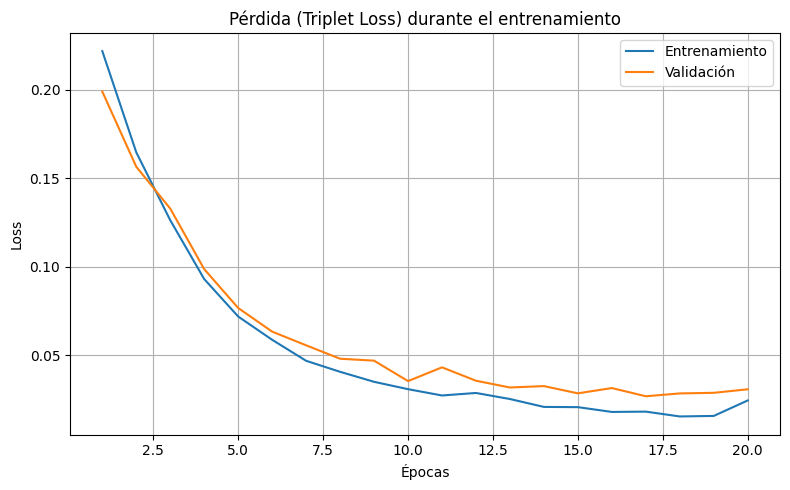

In [73]:
import matplotlib.pyplot as plt

# --- Extraer pérdidas desde el historial ---
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(train_loss) + 1)

# --- Graficar ---
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Entrenamiento")
plt.plot(epochs, val_loss, label="Validación")
plt.title("Pérdida (Triplet Loss) durante el entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### Testing

In [99]:
from pathlib import Path
import librosa
import numpy as np
from tqdm import tqdm

# ---------------------
# 🔧 Parámetros del clip
# ---------------------
nombre_cancion = "yellow_coldplay"  # Cambia según la canción que quieras probar
nombre_clip = "clip11.wav"          # Cambia según el clip que quieras probar
carpeta = "clips_youtube"           # Carpeta donde están los clips

# Rutas
ruta_clip = Path("clips_syntrack") / nombre_cancion / carpeta / "wavs" / nombre_clip
ruta_estudio = Path("clips_syntrack") / nombre_cancion / "cancion_estudio" / f"{nombre_cancion}.wav"

In [101]:
from pathlib import Path
import librosa
import numpy as np
from tqdm import tqdm

# Rutas
ruta_clip = Path("clips_syntrack") / nombre_cancion / carpeta / "wavs" / nombre_clip
ruta_estudio = Path("clips_syntrack") / nombre_cancion / "cancion_estudio" / f"{nombre_cancion}.wav"

# --- Función para procesar audio ---
def procesar_audio(ruta, sr_target, ventana, salto, n_mfcc=20, hop_length=512):
    audio, _ = librosa.load(ruta, sr=sr_target)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr_target, n_mfcc=n_mfcc, hop_length=hop_length)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    stacked = np.vstack([mfcc, delta, delta2])
    stacked = librosa.util.normalize(stacked)

    vectores = []
    for i in range(0, stacked.shape[1] - ventana + 1, salto):
        submat = stacked[:, i:i + ventana]
        if submat.shape[1] == ventana:
            vectores.append(submat.mean(axis=1))
    return np.array(vectores)

# --- Procesar clip ---
print(f"🎧 Procesando clip: {ruta_clip.name}")
vectores_clip = procesar_audio(ruta_clip, sr_target, ventana, salto)
if len(vectores_clip) == 0:
    raise ValueError("Clip demasiado corto para extraer ventanas.")
print(f"✅ Ventanas del clip: {vectores_clip.shape}")

# --- Procesar canción de estudio ---
print(f"🎼 Procesando canción de estudio: {ruta_estudio.name}")
vectores_estudio = procesar_audio(ruta_estudio, sr_target, ventana, salto)
if len(vectores_estudio) == 0:
    raise ValueError("Canción de estudio demasiado corta para extraer ventanas.")
print(f"✅ Ventanas de la canción de estudio: {vectores_estudio.shape}")

# Calcular los segundos correspondientes a cada ventana de la canción de estudio
segundos_estudio = np.arange(0, len(vectores_estudio)) * (salto / sr_target)

# --- Generar embeddings ---
print("🔄 Generando embeddings...")
clip_embeddings = encoder.predict(vectores_clip, verbose=0)
estudio_embeddings = encoder.predict(vectores_estudio, verbose=0)

# --- Embedding representativo del clip (promedio) ---
clip_embedding_promedio = np.mean(clip_embeddings, axis=0)

# --- Calcular distancias directas ---
print("📏 Calculando distancias...")
distancias = []
for i, emb_estudio in enumerate(estudio_embeddings):
    distancia = np.linalg.norm(clip_embedding_promedio - emb_estudio)
    distancias.append(distancia)

# --- Encontrar el mínimo ---
indice_mejor = np.argmin(distancias)
mejor_segundo = indice_mejor * (salto * hop_length / sr_target)

print(f"\n🎯 El modelo predice que el clip coincide mejor con el segundo ~{mejor_segundo:.2f} de la canción original.")

🎧 Procesando clip: clip11.wav
✅ Ventanas del clip: (29, 60)
🎼 Procesando canción de estudio: yellow_coldplay.wav
✅ Ventanas de la canción de estudio: (553, 60)
🔄 Generando embeddings...
📏 Calculando distancias...

🎯 El modelo predice que el clip coincide mejor con el segundo ~1.47 de la canción original.
